# scanorama for monocyte retina  
Refere to [https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_03_integration.html](https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_03_integration.html)

<a name="tableofcontents"></a>
## Table of Contents 
 1 [**Using top 2000 genes within each batch**](#1)    
     1.1 [**Using embedding from scanorama**](#1.1)  
     1.2 [**Using Scanorama-transformed cell-by-gene matrix**](#1.2)  
 2 [**Using all genes within each batch**](#2)    
     2.1 [**Using embedding from scanorama**](#2.1)  
     2.2 [**Using Scanorama-transformed cell-by-gene matrix**](#2.2)  
     

In [1]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from anndata import AnnData
from scipy.io import mmread
import scanorama
import os
from sklearn.metrics.cluster import adjusted_rand_score

/home/xiaoxiang/.local/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/xiaoxiang/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.17.2 scipy==1.4.1 pandas==1.0.0 scikit-learn==0.24.0 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.7.0


In [3]:
scanorama.__version__

'1.7'

In [4]:
#just for test pancreas 
def find_resolution(adata_, n_clusters, random,res_max=2.0):
    """A function to find the louvain resolution tjat corresponds to a prespecified number of clusters, if it exists.
    
    
    Arguments:
    ------------------------------------------------------------------
    - adata_: `anndata.AnnData`, the annotated data matrix of shape (n_obs, n_vars). Rows correspond to cells and columns to low dimension features.
    - n_clusters: `int`, Number of clusters.
    - random: `int`, The random seed.
    
    Returns:
    ------------------------------------------------------------------
    - resolution: `float`, The resolution that gives n_clusters after running louvain's clustering algorithm.
    """
    
    obtained_clusters = -1
    iteration = 0
    resolutions = [0., res_max]
    
    while obtained_clusters != n_clusters and iteration < 50:
        current_res = sum(resolutions)/2
        adata = sc.tl.louvain(adata_, resolution = current_res, random_state = random, copy = True)
        labels = adata.obs['louvain']
        obtained_clusters = len(np.unique(labels))
        
        if obtained_clusters < n_clusters:
            resolutions[0] = current_res
        else:
            resolutions[1] = current_res
        
        iteration = iteration + 1
        
    return current_res

In [5]:
"""Read and normalize the data"""
adata_raw = sc.read("../../raw_data/monocyte_desc_use.h5ad", cache=True)
#adata_raw = sc.read("../data_shared_justin/monocyte/monocyte_desc_use.h5ad", cache=True)
adata_raw.X=adata_raw.X.tocsr()
sc.pp.filter_cells(adata_raw, min_genes=1)
sc.pp.filter_genes(adata_raw, min_cells=30) # must filter that genes with all zeros
mito_genes = adata_raw.var_names.str.startswith('MT-')
adata_raw.obs['percent_mito'] = np.sum(adata_raw[:, mito_genes].X, axis=1).A1 / np.sum(adata_raw.X, axis=1).A1
adata_raw.obs['n_counts'] = adata_raw.X.sum(axis=1).A1
adata_raw = adata_raw[adata_raw.obs['percent_mito'] < 0.05, :]
adata_raw.obs['BatchID'] = adata_raw.obs['dataset_batch'].copy()
adata_raw

Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 10878 × 11160
    obs: 'batch_label', 'cellname', 'dataset_batch', 'dataset_label', 'status_label', 'n_genes', 'n_counts', 'percent_mito', 'BatchID'
    var: 'genename', 'n_cells'

In [6]:
adata_raw

AnnData object with n_obs × n_vars = 10878 × 11160
    obs: 'batch_label', 'cellname', 'dataset_batch', 'dataset_label', 'status_label', 'n_genes', 'n_counts', 'percent_mito', 'BatchID'
    var: 'genename', 'n_cells'

In [7]:
adata_raw.obs.BatchID.value_counts()

RP002    4833
MH001    3640
RP009    2405
Name: BatchID, dtype: int64

In [8]:
adata_raw.obs.BatchID.value_counts().sum()

10878

In [9]:
#adata2 = sc.AnnData(X=adata.X, var=adata.var, obs = adata.obs)
adata2=adata_raw.copy()
sc.pp.normalize_per_cell(adata2, counts_per_cell_after=1e4)
sc.pp.log1p(adata2)
#Detect variable genes

<a name="1"></a>
### 1. Using top 2000 genes within each batch [(top)](#tableofcontents)

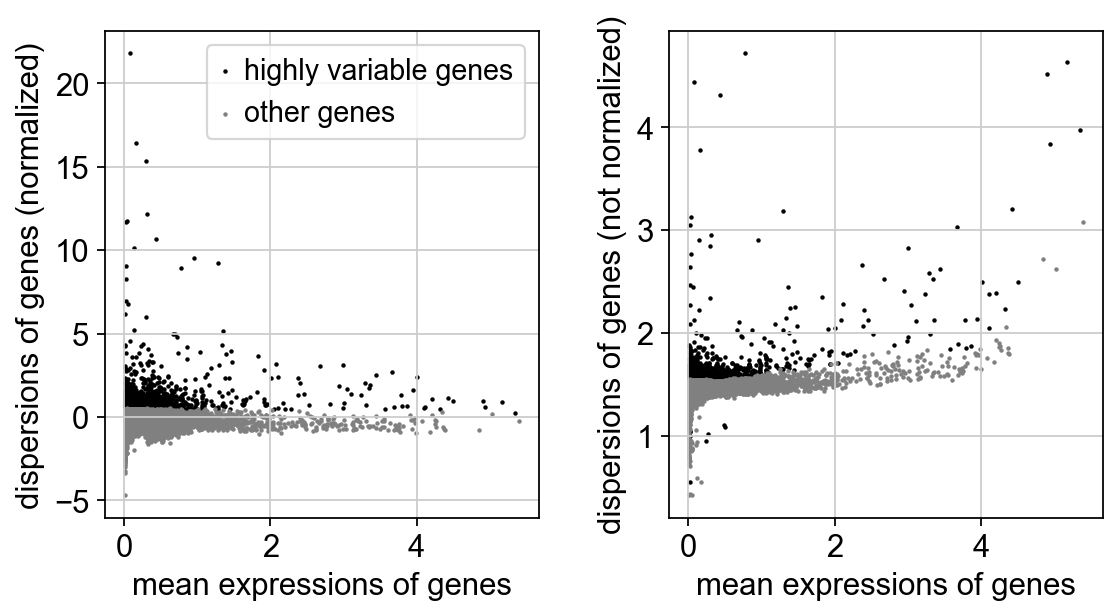

In [10]:
#sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.highly_variable_genes(adata2,n_top_genes=2000,batch_key="BatchID")#
sc.pl.highly_variable_genes(adata2)
var_gene_names1=adata2.var.highly_variable.copy()

In [11]:
batches = adata2.obs['BatchID'].cat.categories.tolist()
alldata = {}
for batch in batches:
    alldata[batch] = adata_raw[adata_raw.obs['BatchID'] == batch,var_gene_names1].copy()

In [12]:
xx=sc.concat(alldata)

In [13]:
# split per batch into new objects.
batches = adata2.obs['BatchID'].cat.categories.tolist()
alldata = {}
for batch in batches:
    alldata[batch] = adata_raw[adata_raw.obs['BatchID'] == batch,var_gene_names1].copy()
#convert to list of AnnData objects
adatas = list(alldata.values())
# run scanorama.integrate
corrected=scanorama.correct_scanpy(adatas, dimred = 50,return_dimred=True)#correct_scanpy,integrate_scanpy

Found 2000 genes among all datasets
[[0.         0.6978022  0.27276507]
 [0.         0.         0.52390852]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


<a name="1.1"></a>
### 1.1 Using embedding from scanorama [(top)](#tableofcontents)

In [14]:
# add to the AnnData object,make sure order are same
adata_tmp=sc.concat(corrected)

In [15]:
# tsne and umap
sc.pp.neighbors(adata_tmp, n_pcs =50, use_rep = "X_scanorama")
sc.tl.umap(adata_tmp)
sc.tl.tsne(adata_tmp, n_pcs = 50, use_rep = "X_scanorama")

/home/xiaoxiang/.local/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


... storing 'batch_label' as categorical
... storing 'dataset_batch' as categorical
... storing 'dataset_label' as categorical
... storing 'BatchID' as categorical


<AxesSubplot:title={'center':'umap_BatchID'}, xlabel='UMAP1', ylabel='UMAP2'>

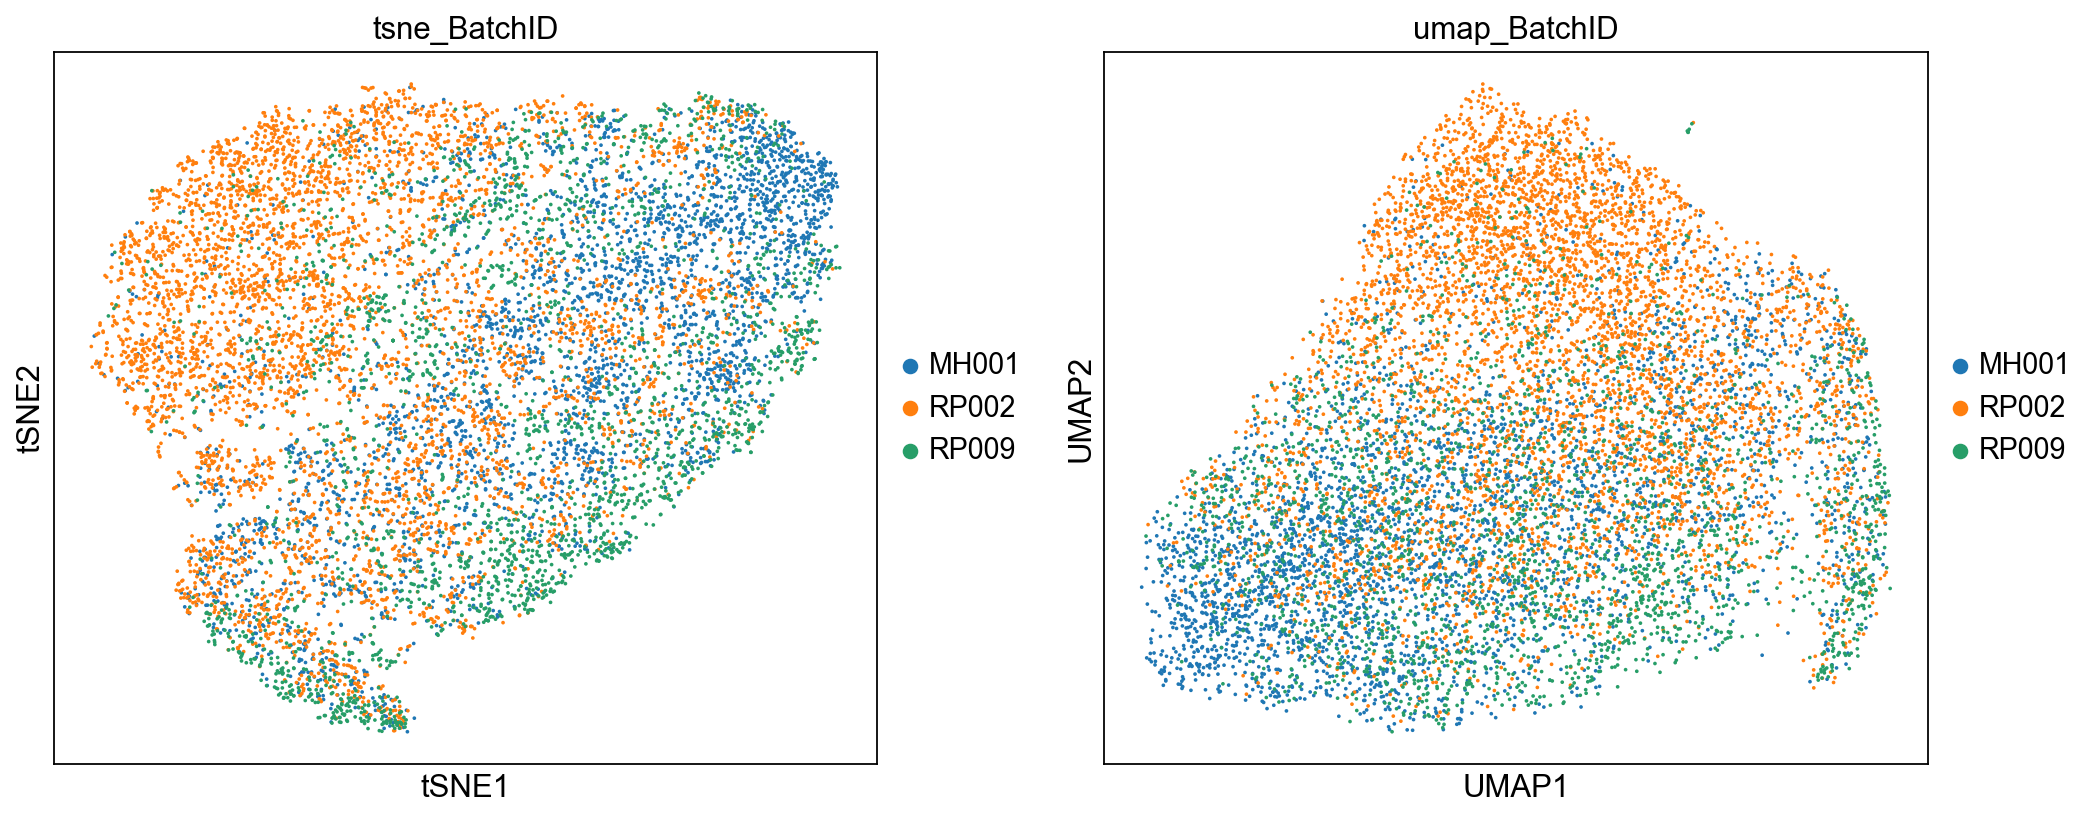

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(13,5),constrained_layout=True)
sc.pl.tsne(adata_tmp, color="BatchID", title="tsne_BatchID", ax=axs[0], show=False)
sc.pl.umap(adata_tmp, color="BatchID", title="umap_BatchID", ax=axs[1], show=False)

<a name="1.2"></a>
### 1.2. Using Scanorama-transformed cell-by-gene matrix [(top)](#tableofcontents)

In [17]:
# add to the AnnData object,make sure order are same
# add to the AnnData object,make sure order are same
#adata_tmp=sc.concat(corrected)
sc.pp.pca(adata_tmp, n_comps=50,svd_solver='arpack')#the pca can be used for monocle3
sc.pp.neighbors(adata_tmp, n_pcs =30)
sc.tl.umap(adata_tmp)
sc.tl.tsne(adata_tmp, n_pcs = 30)

In [18]:
adata_tmp

AnnData object with n_obs × n_vars = 10878 × 2000
    obs: 'batch_label', 'cellname', 'dataset_batch', 'dataset_label', 'status_label', 'n_genes', 'n_counts', 'percent_mito', 'BatchID'
    uns: 'neighbors', 'umap', 'BatchID_colors', 'pca'
    obsm: 'X_scanorama', 'X_umap', 'X_tsne', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

<AxesSubplot:title={'center':'umap_BatchID'}, xlabel='UMAP1', ylabel='UMAP2'>

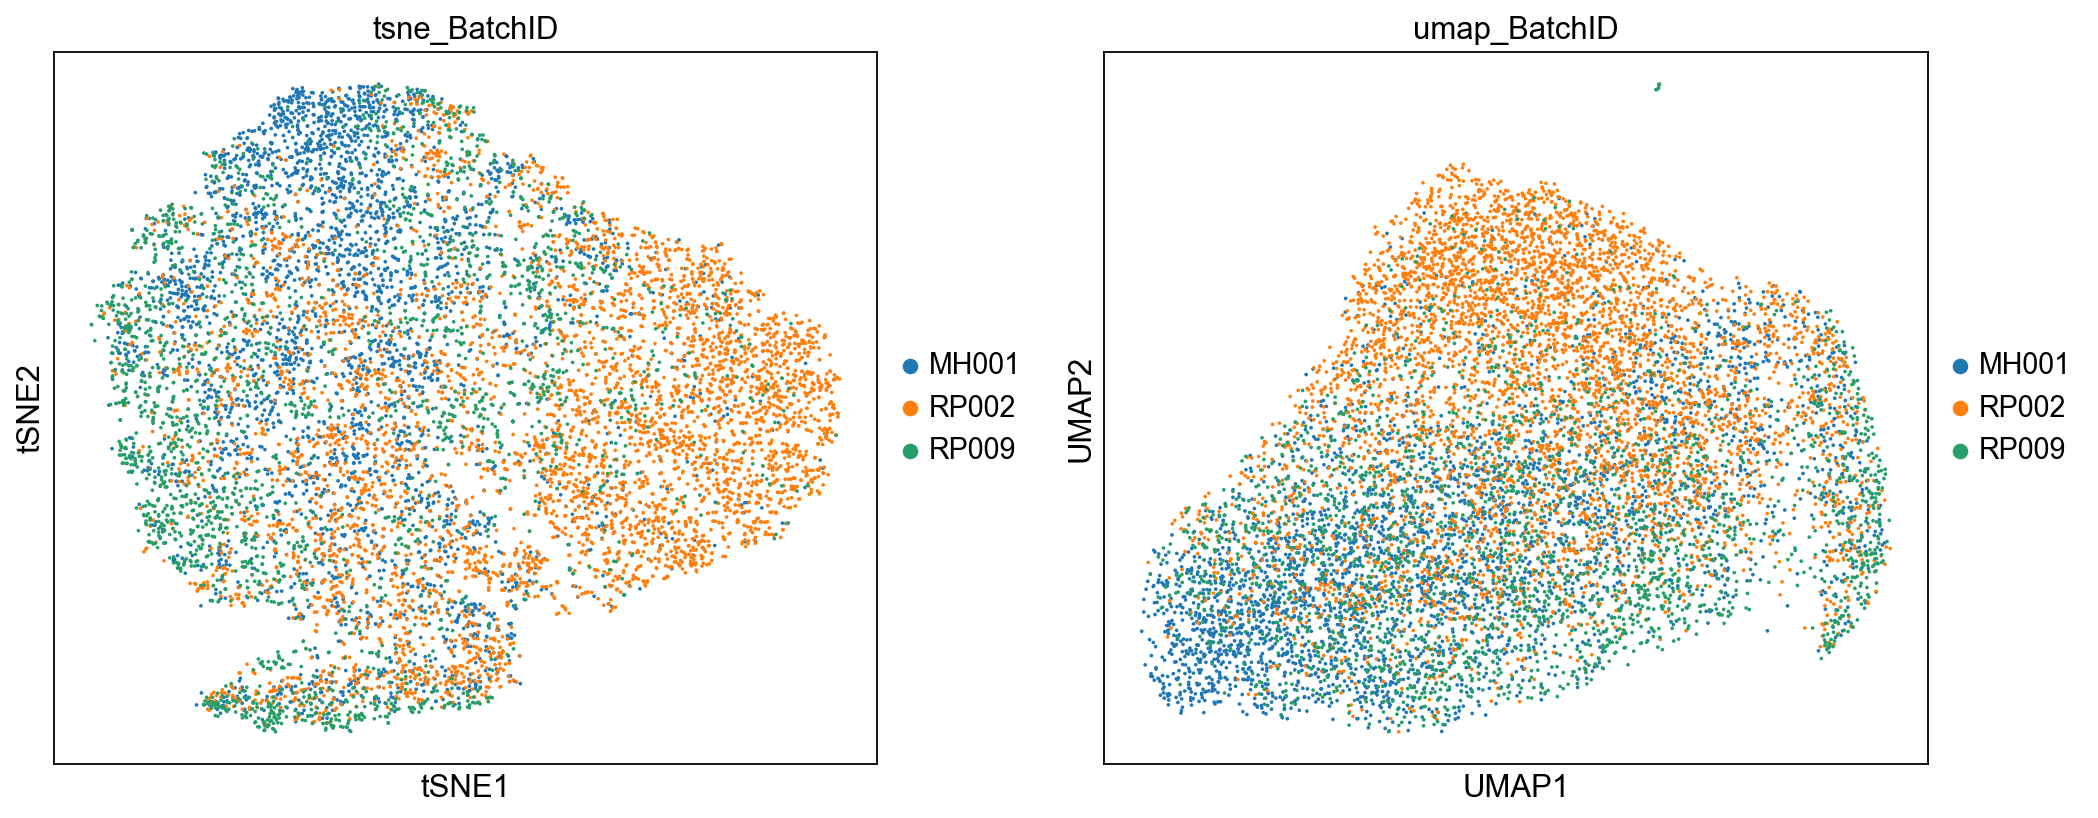

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(13,5),constrained_layout=True)
sc.pl.tsne(adata_tmp, color="BatchID", title="tsne_BatchID", ax=axs[0], show=False)
sc.pl.umap(adata_tmp, color="BatchID", title="umap_BatchID", ax=axs[1], show=False)

> The corrected values from scanorama is not for raw counts, but scaled values, which is different from CarDEC
  or DCA
  
  The shape of corrected data is 

In [20]:
adata_tmp.shape

(10878, 2000)

The count of negative values is 

In [21]:
(adata_tmp.X<0).sum()

10614234

The proportion of negative values is 

In [22]:
(adata_tmp.X<0).mean()

0.48787617209044987

In [23]:
adata_tmp.X[:10,:10].toarray()

array([[-1.9078405e-04,  3.4387302e-04, -5.7584752e-05,  4.5171721e-05,
         1.8379278e-04,  3.2558106e-05, -4.4045481e-04, -4.0068169e-04,
        -3.0361238e-04,  6.2897074e-05],
       [-1.9481171e-05,  1.8764980e-04, -1.5459123e-05,  3.1947322e-06,
         7.6855946e-07, -1.5267653e-04,  1.0494995e-04, -4.4788805e-05,
        -3.2222588e-04, -7.6680726e-06],
       [-4.4511049e-05,  2.4877381e-04, -5.1078752e-07, -1.0415700e-05,
         9.9962934e-05, -3.8972903e-05, -1.0335494e-04, -2.1801238e-04,
         9.7603109e-03, -1.5694079e-04],
       [-2.3675001e-04,  4.6921201e-04,  1.2456074e-04,  2.1232518e-05,
        -2.2134034e-06,  3.4056781e-04, -5.3725566e-04, -3.2706143e-04,
        -7.9533231e-05, -1.3969727e-04],
       [ 1.9463077e-05, -4.9871403e-05,  7.0454334e-05, -3.1654698e-05,
         1.0748647e-04,  1.5240993e-03,  1.2477587e-03, -2.7482345e-04,
         1.1464379e-02, -5.2412557e-05],
       [-1.5498968e-05,  2.2629452e-04,  2.6264266e-05, -1.3955758e-05,
   

In [24]:
#
adata_tmp=adata_tmp[adata_raw.obs_names]
adata_tmp.raw=adata_raw.copy()
adata_tmp.write("./scanorama Results/adata_HVG.h5ad")

<a name="2"></a>
### 2. Using all genes within each batch [(top)](#tableofcontents)

In [25]:
#adata2 = sc.AnnData(X=adata.X, var=adata.var, obs = adata.obs)
adata2=adata_raw.copy()
sc.pp.normalize_per_cell(adata2, counts_per_cell_after=1e4)
sc.pp.log1p(adata2)
#Detect variable genes
var_gene_names1=adata2.var_names

In [26]:
batches = adata2.obs['BatchID'].cat.categories.tolist()
alldata = {}
for batch in batches:
    alldata[batch] = adata_raw[adata_raw.obs['BatchID'] == batch,var_gene_names1].copy()

In [27]:
xx=sc.concat(alldata)

In [28]:
# split per batch into new objects.
batches = adata2.obs['BatchID'].cat.categories.tolist()
alldata = {}
for batch in batches:
    alldata[batch] = adata_raw[adata_raw.obs['BatchID'] == batch,var_gene_names1].copy()
#convert to list of AnnData objects
adatas = list(alldata.values())
# run scanorama.integrate
corrected=scanorama.correct_scanpy(adatas, dimred = 50,return_dimred=True)#correct_scanpy,integrate_scanpy

Found 11160 genes among all datasets
[[0.         0.6717033  0.13555094]
 [0.         0.         0.20790021]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


<a name="2.1"></a>
### 2.1 Using embedding from scanorama [(top)](#tableofcontents)

In [29]:
# add to the AnnData object,make sure order are same
adata_tmp=sc.concat(corrected)

In [30]:
# tsne and umap
sc.pp.neighbors(adata_tmp, n_pcs =50, use_rep = "X_scanorama")
sc.tl.umap(adata_tmp)
sc.tl.tsne(adata_tmp, n_pcs = 50, use_rep = "X_scanorama")

... storing 'batch_label' as categorical
... storing 'dataset_batch' as categorical
... storing 'dataset_label' as categorical
... storing 'BatchID' as categorical


<AxesSubplot:title={'center':'umap_BatchID'}, xlabel='UMAP1', ylabel='UMAP2'>

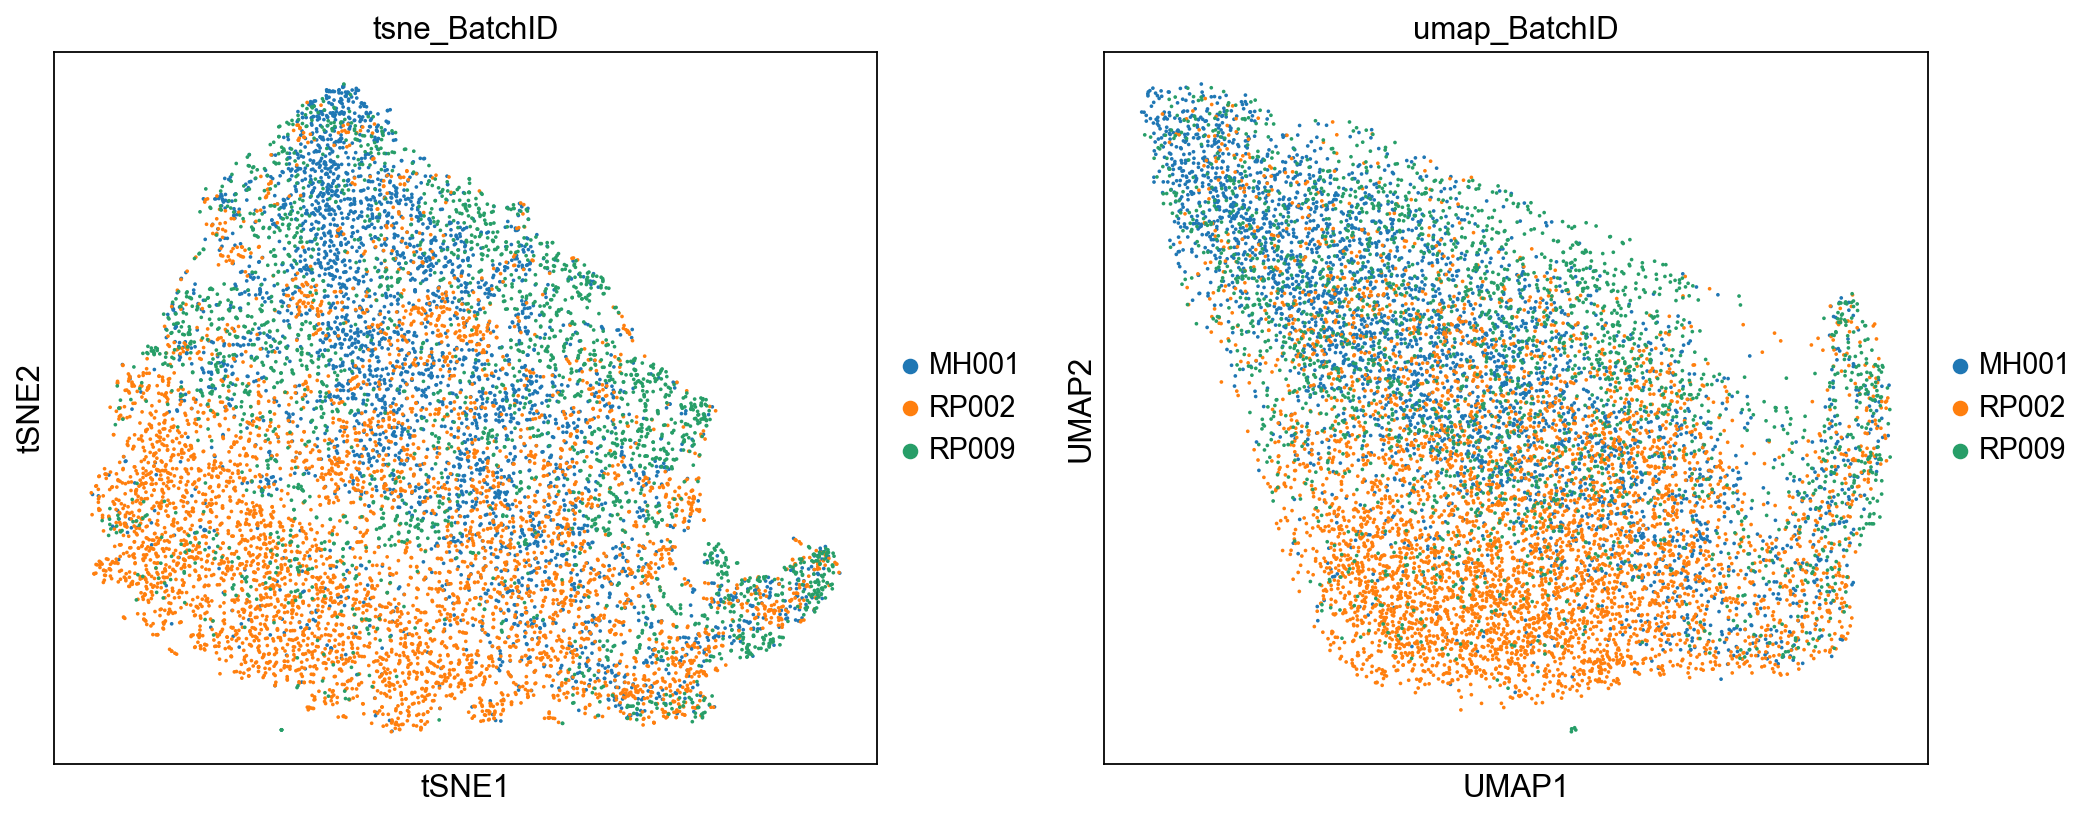

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(13,5),constrained_layout=True)
sc.pl.tsne(adata_tmp, color="BatchID", title="tsne_BatchID", ax=axs[0], show=False)
sc.pl.umap(adata_tmp, color="BatchID", title="umap_BatchID", ax=axs[1], show=False)

In [32]:
#sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.highly_variable_genes(adata2,n_top_genes=2000,batch_key="BatchID")#
var_gene_names1=adata2.var.highly_variable.copy()
adata_tmp0=adata_tmp[:,var_gene_names1]
sc.pp.pca(adata_tmp0, n_comps=50,svd_solver='arpack')#the pca can be used for monocle3
adata_tmp.obsm["X_hvgpca"]=adata_tmp0.obsm['X_pca']

<a name="2.2"></a>
### 2.2. Using Scanorama-transformed cell-by-gene matrix [(top)](#tableofcontents)

In [33]:
# add to the AnnData object,make sure order are same
# add to the AnnData object,make sure order are same
#adata_tmp=sc.concat(corrected)
sc.pp.pca(adata_tmp, n_comps=50,svd_solver='arpack')#the pca can be used for monocle3
sc.pp.neighbors(adata_tmp, n_pcs =30)
sc.tl.umap(adata_tmp)
sc.tl.tsne(adata_tmp, n_pcs = 30)

<AxesSubplot:title={'center':'umap_BatchID'}, xlabel='UMAP1', ylabel='UMAP2'>

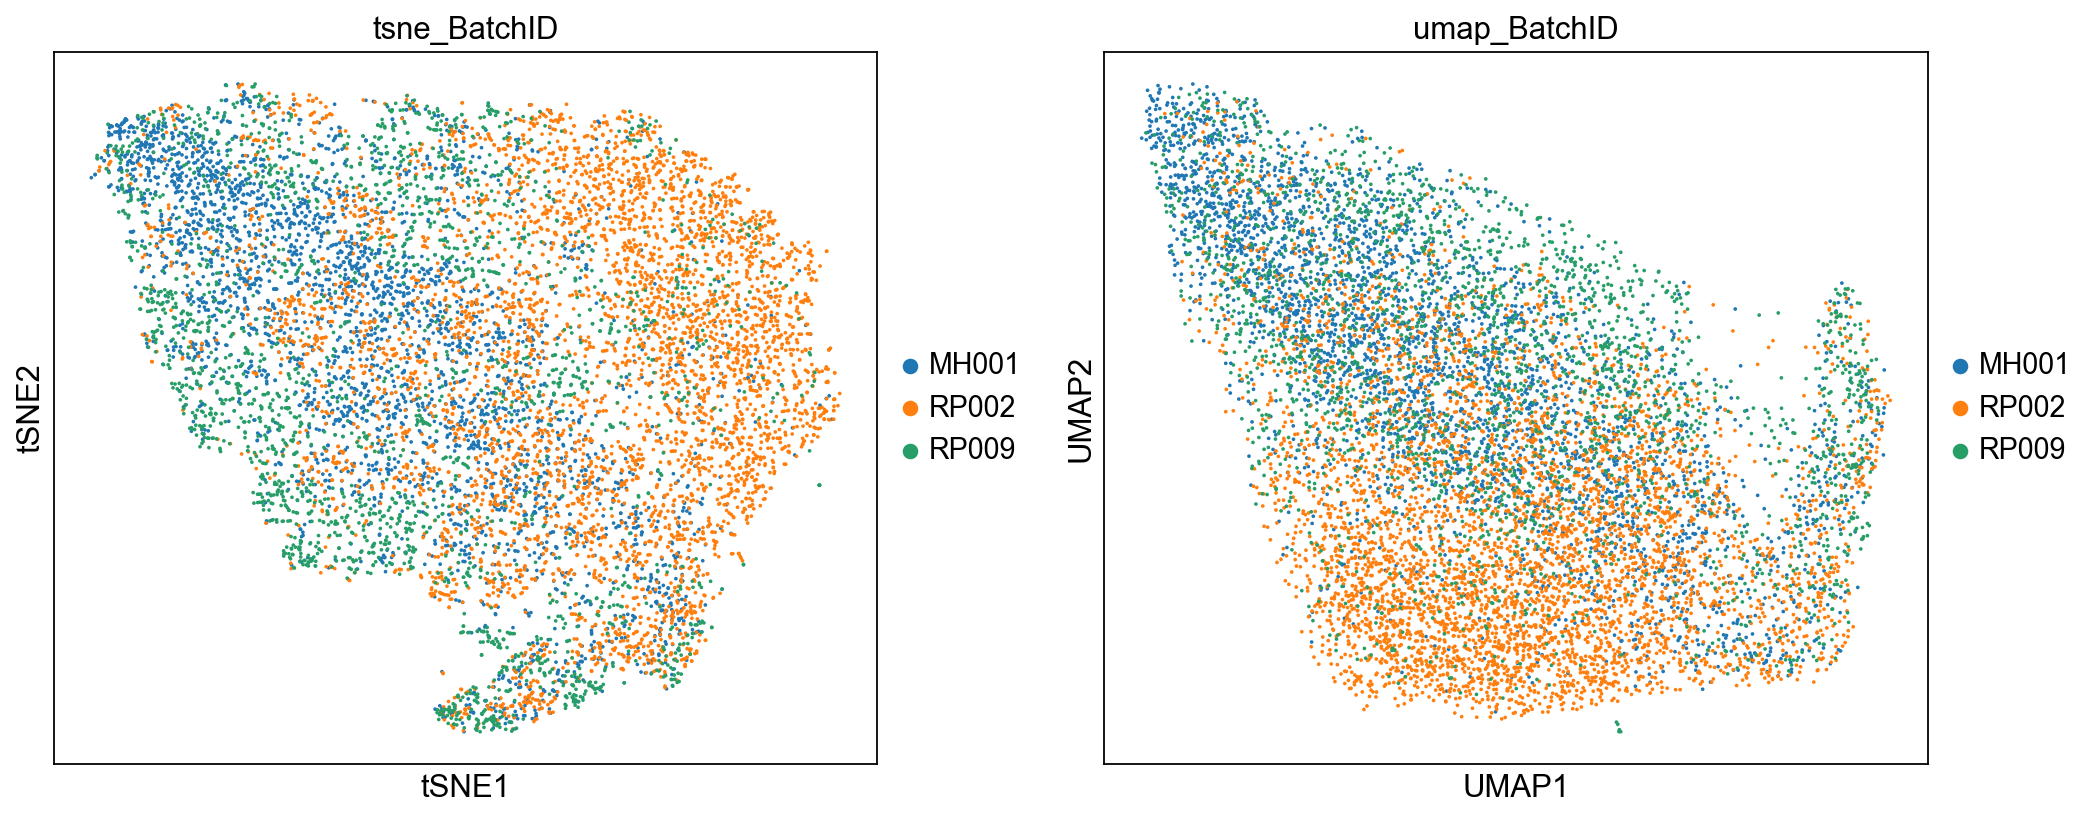

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(13,5),constrained_layout=True)
sc.pl.tsne(adata_tmp, color="BatchID", title="tsne_BatchID", ax=axs[0], show=False)
sc.pl.umap(adata_tmp, color="BatchID", title="umap_BatchID", ax=axs[1], show=False)

> The corrected values from scanorama is not for raw counts, but scaled values, which is different from CarDEC
  or DCA
  
  The shape of corrected data is 

In [35]:
adata_tmp.shape

(10878, 11160)

The count of negative values is 

In [36]:
(adata_tmp.X<0).sum()

62940174

The proportion of negative values is 

In [37]:
(adata_tmp.X<0).mean()

0.5184593250260898

In [38]:
adata_tmp.X[:10,:10].toarray()

array([[-1.71556734e-04, -2.18836740e-05,  3.00640222e-05,
         1.80758343e-05,  1.02105814e-05, -5.15638785e-05,
         4.17766714e-05, -1.10394561e-04, -1.89303668e-04,
        -4.53309585e-05],
       [-2.17104811e-04,  2.78374669e-03,  9.36327410e-07,
         9.08200127e-06,  9.24734850e-05, -1.17466789e-05,
         2.80517596e-03, -1.70144413e-04,  5.37298666e-03,
         1.00037332e-05],
       [-1.60323907e-04,  7.03843125e-06,  3.26535082e-05,
         3.01991367e-05,  1.16492534e-04, -8.47603369e-05,
         1.39989270e-05, -1.59043368e-04, -1.73356064e-04,
        -2.56781714e-05],
       [-1.56680602e-04, -4.24381278e-06,  3.24530879e-06,
         1.95834164e-05,  1.03519946e-04, -1.02314996e-04,
         2.48771656e-04, -2.51359656e-04, -3.37810547e-04,
        -2.51655656e-05],
       [ 1.33269095e-05, -4.88508231e-05,  9.20830207e-05,
        -3.40524675e-05,  2.11522041e-04, -7.61760675e-05,
        -6.04351808e-05,  1.07193808e-03,  8.99825536e-04,
         1.

In [39]:
#
adata_tmp=adata_tmp[adata_raw.obs_names]#re-order
adata_tmp.raw=adata_raw.copy()
adata_tmp.write("./scanorama Results/adata_ALL.h5ad")

In [41]:
adata_tmp.raw